# Interjection Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import gender_classification as gc
from collections import Counter

In [2]:
# load data
df = pd.read_pickle('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/data_topics_revised.pkl')

In [3]:
# add year column
df['year'] = df['date'].dt.year

In [4]:
df.head()

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution,year
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655},2021
1,Herr Präsident! Liebe Kolleginnen und Kolleg...,2021-10-26,20,Stefan Müller,male,None,CDU/CSU,[(Beifall bei der CDU/CSU sowie bei Abgeordnet...,SP-2021-1,4028,3796,{68: 0.46776655},2021
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164},2021
3,Sehr geehrter Herr Präsident! Meine lieben K...,2021-10-26,20,Marco Buschmann,male,None,FDP,"[(Jan Korte [DIE LINKE]: Oder Jugendweihe!), (...",SP-2021-3,3083,4555,{},2021
4,Herr Alterspräsident! Lassen Sie mich zunäch...,2021-10-26,20,Stephan Brandner,male,None,AfD,"[(Beifall bei der AfD), (Beifall bei Abgeordne...",SP-2021-4,4055,5996,{68: 0.3120498},2021


In [5]:
# filter dataframe for speeches with comments
df_comments = df[df['comments'].apply(lambda x: len(x) > 0)]

In [6]:
# number of speeches with comments
len(df_comments)

371023

## Matching and counting comments

### Classifying speaker gender

In [7]:
# function for classifying speaker gender by preambles # TODO Classify if approval or disapproval
PRE_1 = re.compile(r'(((Weiterer )?(Gegenruf|Zuruf) (?P<article>des|der) Abg\.))(?P<name>[\w,\s\.]*)')
PRE_2 = re.compile(r'(((Zuruf|Zustimmung) (?P<article>des|der) Abg\.)|(Zuruf von))(?P<name>[\w,\s\.]*)')
PRE_3 = re.compile(r'(.*?)\s*--\s*(?P<name>[\w\s\.-]+)$')

PREAMBLES = [PRE_1, PRE_2, PRE_3]

def get_speaker_gender_by_preamble(comment):
    for PREAMBLE in PREAMBLES:
            match = re.search(PREAMBLE, comment)
            if(match):
                comment = match.groupdict()["name"]
                if 'article' in match.groupdict():
                    article = match.groupdict()["article"]
                    return 'female' if article == 'der' else 'male'

In [8]:
# test classification
get_speaker_gender_by_preamble("Weiterer Gegenruf des Abg. Müller: So ein Quatsch, Herr Hauchler!")

'male'

In [9]:
# function for cleaning and classifying speaker names
def get_speaker_gender_by_name(name):

    gender_by_preamble = get_speaker_gender_by_preamble(name)
    if gender_by_preamble:
        return gender_by_preamble
    
    name = name.strip()
    name_length = len(name.split())

    if name_length > 1:
        # remove 'Abgeordnete(r)' from name
        name = re.sub('Abg\.?', '', name).strip()

        # if name 'Frau X', classify as female
        if name.split()[0] == 'Frau':
            return 'female'
        
        # if first substring is title, take second substring or return unknown
        if "." in name.split()[0]:
            if name_length > 2 :
                first_name = name.split()[1]
            else:
                return 'unkown'
        else:
            first_name = name.split()[0]
        return gc.get_gender(first_name)
    
    # return unknown if only last name is given
    else:
        return 'unknown'

In [10]:
# test classification
get_speaker_gender_by_name("Weiterer Zuruf des Abg. Kai Gehring")

'male'

### Cleaning comments

In [11]:
# dict of faulty characters and names to replace
chars_to_replace = {
    '\xa0': ' ',
    '…': '...',
    '\u202f': '',
    '„': '"',
    '”': '"',
    '“': '"',
    '§': 'Paragraph',
    '\n                   ': '',
    'Prinz zu Sayn-Wittgenstein-Hohenstein': 'Botho Prinz zu Sayn-Wittgenstein-Hohenstein',
    'Dr.Kohl': 'Dr. Kohl',
    'Dr. -Ing.': 'Dr.-Ing.',
}

In [12]:
# function for replacing in-comment hyphens (that are not used for separation between comments)
def replace_hyphens(string):
    hyphen = re.compile(r'[a-zA-Z\.\"]+(?P<hyphen>-)[a-zA-Z\.]+')

    matches = hyphen.finditer(string)
    hyphens_pos = []

    for match in matches:
        if 'hyphen' in match.groupdict():
            pos = match.start(1)
            hyphens_pos.append(pos)

    cleaned_str = string 
    for pos in hyphens_pos:
        cleaned_str = cleaned_str[: pos] + ' ' + cleaned_str[pos + 1:]

    return cleaned_str

In [13]:
# test hyphen replacement
test_string = "(Rawe [CDU/CSU] : Er hat den-Kanzler gemeint! — Seiters [CDU/CSU]: Meinen Sie die Dr.-Ing SPD-Flügel? — Franke [Osnabrück] [CDU/CSU]: Meinen Sie Herrn-Bangemann? — Weitere Zurufe von der CDU/CSU)"

replace_hyphens(test_string)

'(Rawe [CDU/CSU] : Er hat den Kanzler gemeint! — Seiters [CDU/CSU]: Meinen Sie die Dr. Ing SPD Flügel? — Franke [Osnabrück] [CDU/CSU]: Meinen Sie Herrn Bangemann? — Weitere Zurufe von der CDU/CSU)'

In [14]:
# function for cleaning unmatched interjections in multiple-comment-string
to_remove = [' ', '']
separators = r'—|–'

def clean_rest_comments(rest_string):
    rest_string = re.sub('[()]', '', rest_string)
    comments = re.split(separators, rest_string)
    comments = [c for c in comments if c not in to_remove]

    for index, comment in enumerate(comments):
        comments[index] = comment.strip()

    return comments

### Classifying reactions

In [15]:
# function for classifying reaction interjections
def check_reaction(interjection):
    cheerful_reactions = ['Heiterkeit', 'Heiterkeit und Beifall', 'Beifall und Heiterkeit']
    disgust_pattern = re.compile(r'(Pfui Rufe?)|(Pfui)')

    for reaction in cheerful_reactions:
        if reaction in interjection:
            return 'cheerfulness'
    if 'Beifall' in interjection:
        return 'applause'
    elif 'Unruhe' in interjection:
        return 'disquiet'
    elif 'Lachen' in interjection:
        return 'laughter'
    elif 'Zustimmung' in interjection:
        return 'approval'
    elif disgust_pattern.search(interjection) is not None:
        return 'disgust'
    elif 'Widerspruch' in interjection:
        return 'objection'
    else:
        return

In [16]:
all_reactions = ['applause', 'cheerfulness', 'laughter', 'approval', 'disgust', 'disquiet', 'objection']

In [17]:
def check_rest_comment(comment):
    reactions = []
    female_speaker_count = 0
    male_speaker_count = 0

    unmatched_comments = clean_rest_comments(comment)
    
    for unmatched_comment in unmatched_comments:
        reaction = check_reaction(unmatched_comment)
        if(reaction): 
            reactions.append(reaction)

        if get_speaker_gender_by_preamble(unmatched_comment) == 'female':
            female_speaker_count += 1
        if get_speaker_gender_by_preamble(unmatched_comment) == 'male':
            male_speaker_count += 1
        

    return reactions, female_speaker_count, male_speaker_count

In [18]:
check_rest_comment("(Beifall bei der AfD – – Weiterer Zuruf des Abg. Norbert Kleinwächter [AfD])")

(['applause'], 0, 1)

### Counting comment types and identifying speakers and their gender

In [19]:
# recognizes comments of named speakers
RE_SPEAKER_DIRECTLY = re.compile(r'(?P<speaker>[\w]+[\w\s\.]*) \[(?P<party>[\w,/\s]*)\]: (?P<comment>[\w,!\s\.\?\":]*)( - )*')

RES = [RE_SPEAKER_DIRECTLY]

comment_counts = {}
comment_speakers = {}
comment_fem_speakers = {}
comment_male_speakers = {}
reaction_counts = {}

# comment in all the print statements to assemble a text file containing all comment and reaction matches
# f = open('reference files/matches.txt', 'w', encoding='utf-8')

for index, speech in df_comments.iterrows():
    # print(f"Speech {index}:", file=f)
    comment_count = 0
    speakers = []
    fem_speakers = 0
    male_speakers = 0
    reactions = []

    for comment in speech['comments']:
        # clean comments
        for key, value in chars_to_replace.items():
            comment = comment.replace(key, value)
        comment = replace_hyphens(comment)

        # search for regex
        for RE in RES:
            rest_str = comment

            if re.search(RE, comment) is not None:
                matches = RE.finditer(comment)
                # print(f"    Matches found in comment: {comment}", file=f)

                for match in matches:
                    if 'speaker' in match.groupdict():
                        speaker = match.groupdict()['speaker']
                        comment_count += 1
                        # print(f"        Match: {match.group()}", file=f)

                        if speaker != "":
                            speakers.append(speaker)
                    
                    # get unmatched comments
                    rest_str = rest_str.replace(match.group(), '')
                    if rest_str != "()":
                        reactions_in_comment, female_speaker_count, male_speaker_count = check_rest_comment(rest_str)
                        reactions.extend(reactions_in_comment)
                        fem_speakers += female_speaker_count
                        male_speakers += male_speaker_count
                        # print(f"    Unmatched Rest-Comment: {rest_str}", file=f)
                        # if (len(reactions_in_comment) > 0):
                        #     print(f"    Found {len(reactions_in_comment)} reactions in: {rest_str}", file=f)
                        #     print(f"        Reactions: {reactions_in_comment}", file=f)
            
            # if no direct speaker match, check for reactions
            else:
                reactions_in_comment, female_speaker_count, male_speaker_count = check_rest_comment(rest_str)
                reactions.extend(reactions_in_comment)
                fem_speakers += female_speaker_count
                male_speakers += male_speaker_count
                # if (len(reactions_in_comment) > 0):
                #     print(f"    Found {len(reactions_in_comment)} reactions in: {comment}", file=f)
                #     print(f"        Reactions: {reactions_in_comment}", file=f)

    # get speaker gender
    for speaker in speakers:
        if get_speaker_gender_by_name(speaker) == 'female':
            fem_speakers += 1
        if get_speaker_gender_by_name(speaker) == 'male':
            male_speakers += 1

    comment_counts[index] = comment_count
    comment_speakers[index] = speakers
    comment_fem_speakers[index] = fem_speakers
    comment_male_speakers[index] = male_speakers
    reaction_counts[index] = Counter(reactions)

# f.close()

In [20]:
# get comment count by speech id
comment_counts[2]

3

In [21]:
len(comment_counts)

371023

In [22]:
# get total counts of comments and reactions
total_count_comments = Counter(comment_counts).total()
total_count_reactions = 0

for reactions in reaction_counts.values():
    total_count_reactions = total_count_reactions + Counter(reactions).total()

print(f'''
      Total Count of Direct Speaker Comments: {total_count_comments}
      Total Count of Reactions: {total_count_reactions}
      ''')


      Total Count of Direct Speaker Comments: 601690
      Total Count of Reactions: 1133955
      


In [ ]:
# add columns for comment- and speaker gender count
df_comments['comment_count'] = comment_counts.values()
df_comments['comment_fem_speakers'] = comment_fem_speakers.values()
df_comments['comment_male_speakers'] = comment_male_speakers.values()
df_comments['reaction_count'] = reaction_counts.values()

In [24]:
df_comments.head()

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution,year,comment_count,comment_fem_speakers,comment_male_speakers,reaction_count
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655},2021,0,0,0,{'applause': 2}
1,Herr Präsident! Liebe Kolleginnen und Kolleg...,2021-10-26,20,Stefan Müller,male,None,CDU/CSU,[(Beifall bei der CDU/CSU sowie bei Abgeordnet...,SP-2021-1,4028,3796,{68: 0.46776655},2021,4,5,2,{'applause': 7}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164},2021,3,2,2,{'applause': 9}
3,Sehr geehrter Herr Präsident! Meine lieben K...,2021-10-26,20,Marco Buschmann,male,None,FDP,"[(Jan Korte [DIE LINKE]: Oder Jugendweihe!), (...",SP-2021-3,3083,4555,{},2021,1,0,1,"{'cheerfulness': 1, 'applause': 3}"
4,Herr Alterspräsident! Lassen Sie mich zunäch...,2021-10-26,20,Stephan Brandner,male,None,AfD,"[(Beifall bei der AfD), (Beifall bei Abgeordne...",SP-2021-4,4055,5996,{68: 0.3120498},2021,4,3,1,"{'applause': 10, 'laughter': 1}"


In [25]:
df_comments["reaction_count"][15742] #["applause"]

Counter({'objection': 1, 'disgust': 1})

In [26]:
# test comment count and speaker classification per speech
RE_SPEAKER_DIRECTLY = re.compile(r'(?P<speaker>[\w]+[\w\s\.-]*) \[(?P<party>[\w,/\s]*)\]: (?P<comment>[\w,!\s\.\?\"]*)( - )*')

RES = [RE_SPEAKER_DIRECTLY]

for comment in df_comments["comments"][15742]: # insert speech id here
    for RE in RES:
        if re.search(RE, comment) is not None:
            for match in re.finditer(RE, comment):
                print(match.groupdict())
        else:
            print(f"no direct speaker comment: {comment}")

no direct speaker comment: (Zuruf.)
no direct speaker comment: (Widerspruch in der Mitte und rechts.)
no direct speaker comment: (Zurufe rechts und Gegenrufe links.)
no direct speaker comment: (Hört! Hört! bei der SPD.)
no direct speaker comment: (Hört! Hört! — Abg. Hilbert: Pfui! - Weitere Pfui-Rufe rechts. — Glocke des Präsidenten.)


## Calculating Means per Gender

In [27]:
comment_stats = {
    'female': [],
    'male': []
    }

In [28]:
# calculate average comment count per speech by gender
average_comments_by_gender = df_comments.groupby('speaker_gender')['comment_count'].mean()
average_comments_by_gender

speaker_gender
female    1.632006
male      1.618209
Name: comment_count, dtype: float64

In [29]:
# calculate average count of female commentators per speech by gender
female_commentators_by_gender = df_comments.groupby('speaker_gender')['comment_fem_speakers'].mean()
female_commentators_by_gender

speaker_gender
female    0.417182
male      0.386773
Name: comment_fem_speakers, dtype: float64

In [30]:
# calculate average count of male commentators per speech by gender
male_commentators_by_gender = df_comments.groupby('speaker_gender')['comment_male_speakers'].mean()
male_commentators_by_gender

speaker_gender
female    1.321145
male      1.288469
Name: comment_male_speakers, dtype: float64

In [31]:
# calculate average count of reactions per speech by gender
reactions_by_gender = df_comments.groupby('speaker_gender')['reaction_count']

avg_reactions_male_speeches = pd.json_normalize(reactions_by_gender.get_group("male")).mean()
avg_reactions_fem_speeches = pd.json_normalize(reactions_by_gender.get_group("female")).mean()

print(f"    female speeches:\n{avg_reactions_fem_speeches}\n    male speeches:\n{avg_reactions_male_speeches}")

    female speeches:
applause        3.445165
disquiet        1.144841
laughter        1.238906
cheerfulness    1.225658
objection       1.149581
approval        1.283140
disgust         1.079710
dtype: float64
    male speeches:
applause        3.650318
cheerfulness    1.501184
laughter        1.357033
objection       1.176043
approval        1.356110
disgust         1.218073
disquiet        1.256039
dtype: float64


### Assemble Dataframe for Stats

In [ ]:
for gender in ['male', 'female']:
    comment_stats[gender].extend([average_comments_by_gender[gender], female_commentators_by_gender[gender], male_commentators_by_gender[gender]])

for reaction in all_reactions: # use list of reactions to ensure correct order
    comment_stats['male'].append(avg_reactions_male_speeches[reaction])
    comment_stats['female'].append(avg_reactions_fem_speeches[reaction])

comment_stats

In [33]:
# get column names
def get_columns():
    comment_stats = ['avg_comments_per_speech', 'avg_female_commentators', 'avg_male_commentators']
    reaction_stats = []

    for reaction in all_reactions:
        reaction_stats.append(f'avg_{reaction}')

    comment_stats.extend(reaction_stats)

    return comment_stats

get_columns()

['avg_comments_per_speech',
 'avg_female_commentators',
 'avg_male_commentators',
 'avg_applause',
 'avg_cheerfulness',
 'avg_laughter',
 'avg_approval',
 'avg_disgust',
 'avg_disquiet',
 'avg_objection']

In [34]:
# create dataframe
df_comment_stats = pd.DataFrame.from_dict(comment_stats, orient='index', columns=get_columns())
df_comment_stats

,avg_comments_per_speech,avg_female_commentators,avg_male_commentators,avg_applause,avg_cheerfulness,avg_laughter,avg_approval,avg_disgust,avg_disquiet,avg_objection
female,1.632006,0.417182,1.321145,3.445165,1.225658,1.238906,1.28314,1.079710,1.144841,1.149581
male,1.618209,0.386773,1.288469,3.650318,1.501184,1.357033,1.35611,1.218073,1.256039,1.176043


## Plot Interjection Stats

In [35]:
# function for formatting dataframe column names into x_labels
to_replace = {
    '_': ' ',
    'avg': '',
    ' ': '\n'
}

def get_stat_labels(stats):
    stats = list(map(lambda stat: format_label(str(stat)), stats))
    return stats


def format_label(label):
    for key, value in to_replace.items():
        label = label.replace(key, value)
    
    label = label.strip().title()
        
    return label

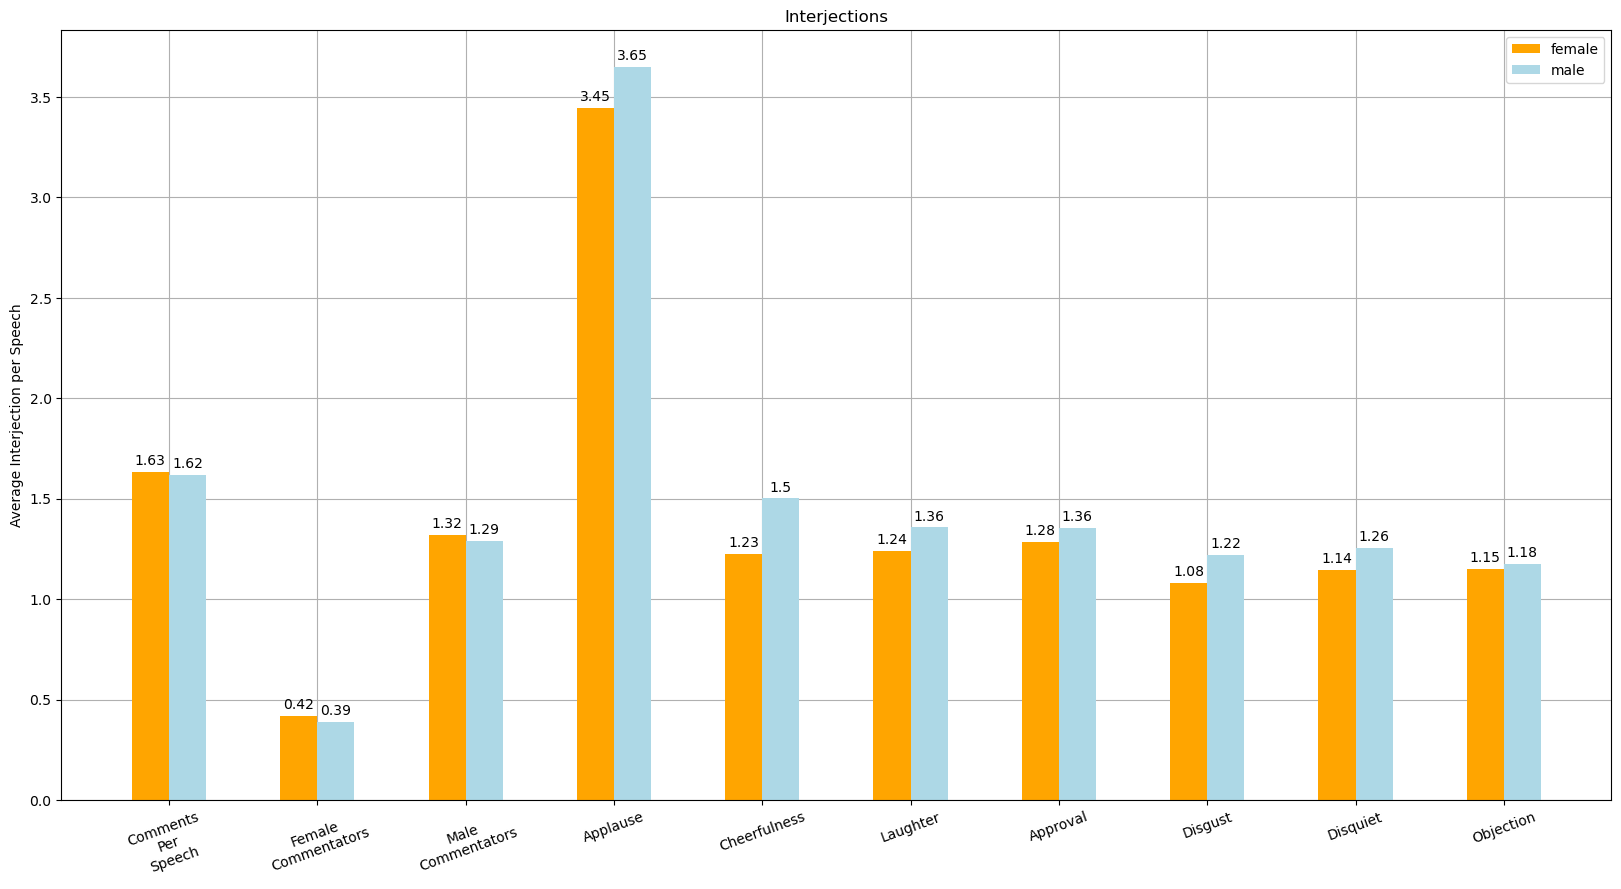

In [36]:
stats = df_comment_stats.columns
x = np.arange(len(stats))
width = 0.25 # bar width
multiplier = 0

fig, ax = plt.subplots(figsize=(20, 10))
colors = {'female': 'orange', 'male': 'lightblue'}

for gender in ['female', 'male']:
    values = df_comment_stats.loc[gender].values
    offset = width * multiplier
    rects = ax.bar(
        x + offset, 
        values, 
        width, 
        label=gender,
        color=colors[gender]
        )
    ax.bar_label(rects, np.round(values, decimals=2), padding=3)
    multiplier += 1

ax.set_ylabel('Average Interjection per Speech')
ax.set_title('Interjections')
ax.set_xticks(x + width / 2, get_stat_labels(stats), rotation=20)
ax.legend()
plt.grid(True)
ax.set_axisbelow(True)

plt.show()

In [160]:
# TODO split reaction and comment plot